In [1]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost_order import process_kline, inference
from helper import get_binance_ohlc_time, generate_date_list, calculate_rsi_with_ema, is_decrease, is_pin_bar, generate_df_klines
import random
TRAINING = False
INFERENCE_XG = False

In [14]:
def rule(df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []

    index_condition = []
    pick_index = []

    if model is None:
        index_condition = random.sample(range(100, len(df)), num_random)
        index_condition.sort()
        #and df.iloc[i-2]['close'] >= df.iloc[i-2]['open'] and  df.iloc[i-3]['close'] >= df.iloc[i-3]['open']
        for i in index_condition:
            if df.iloc[i-1]['close'] < df.iloc[i-1]['open']  and df.iloc[i-2]['Trend'] == 1 and df.iloc[i-3]['Trend'] == 1:
                for j in range (i, i+3):
                    if df.iloc[j]['high'] > df.iloc[i-1]['open']:
                        pick_index.append((j, df.iloc[i-1]['open']))
                        break
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.loc[i-seq:i-1, ["open", "high", "low", "close", "volumn"]].to_numpy()
            x_array_cp = x_array.copy()
            rsi_6 = calculate_rsi_with_ema(x_array, 6)
            y_pred_prob = inference(x_array, model)
            if y_pred_prob == 1:
                if manual_cond:
                    # if is_decrease(x_array_cp[-1]) or is_decrease(x_array_cp[-2]) or is_pin_bar(x_array_cp[-1]): 
                    if rsi_6[-1] > 20 and rsi_6[-2] > 20:
                        index_condition.append(i)
                else:
                    index_condition.append(i)
        index_condition = sorted(index_condition)
    # print([i[0] for i in pick_index])
    for (i,open_price_i) in pick_index:
        low_sma = False
        
        # open_price_i = df['open'].iloc[i]
        high_check = False
        low_check = False
        open_time = df.iloc[i]['timestamp']
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            low_sma = df['low'].iloc[j] < df['lower'].iloc[j] * 1.002
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * open_price_i
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * open_price_i
            # if low_sma:
            #     print(open_time, "low sma")
            #     pnl = money * (1 - df['lower'].iloc[j] * 1.002 / open_price_i)
            #     balance += pnl
            #     list_reward.append(balance)
            #     results.append((i, open_time,j,open_price_i, "sma", round(pnl,2)))
            #     number_low+=1
            #     low_check = True
            #     break
            if (high_check and low_check) or (high_check and low_sma):
                print("check lai")
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, open_time,j, df.iloc[j]['timestamp'],open_price_i, "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, open_time,j, df.iloc[j]['timestamp'], open_price_i, "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < open_price_i:
                pnl = money * (1 - df.iloc[j]['close'] / open_price_i)
                balance += pnl
            else:
                pnl = -money * (df.iloc[j]['close'] / open_price_i-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, open_time,j, "not",open_price_i, df.iloc[j]['close'], round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, pick_index, number_high, number_low, list_reward, prices_list

# Inference


In [3]:
if INFERENCE_XG:
    bst = xgb.Booster()
    bst.load_model('./weights/ORDIUSDT_15m_tp3_sl3_60pcent_mancond_fapiv1.json')


In [4]:
threshold = 0.01

def classify_trend(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] > row['SMA'] * (1 + threshold):
        return 2
    elif row['close'] < row['SMA'] * (1 - threshold):
        return 1
    else:
        return 0
    
def classify_trend_through(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] < row['SMA'] * (1 - threshold) and row['open'] > row['SMA']:
        return 1
    else:
        return 0
    
def classify_trend_bollband(row):
    if pd.isna(row['upper']):
        return None  # Không đủ dữ liệu để phân loại
    elif (row['low'] + row['high'])/2 > row['upper']:
        return 1
    elif (row['low'] + row['high'])/2 < row['lower']:
        return 2
    else:
        return 0



In [5]:
df_all, csv_link = generate_df_klines(start = "2023-03-10", end = "2025-03-20", symb = "ORDIUSDT", interval = "4h", split_day=64)

2023-03-10 00:05:00 -> 2023-05-13 00:03:00
https://api.mexc.com/api/v3/klines
2023-05-13 00:05:00 -> 2023-07-16 00:03:00
https://api.mexc.com/api/v3/klines
2023-07-16 00:05:00 -> 2023-09-18 00:03:00
https://api.mexc.com/api/v3/klines
2023-09-18 00:05:00 -> 2023-11-21 00:03:00
https://api.mexc.com/api/v3/klines
2023-11-21 00:05:00 -> 2024-01-24 00:03:00
https://api.mexc.com/api/v3/klines
2024-01-24 00:05:00 -> 2024-03-28 00:03:00
https://api.mexc.com/api/v3/klines
2024-03-28 00:05:00 -> 2024-05-31 00:03:00
https://api.mexc.com/api/v3/klines
2024-05-31 00:05:00 -> 2024-08-03 00:03:00
https://api.mexc.com/api/v3/klines
2024-08-03 00:05:00 -> 2024-10-06 00:03:00
https://api.mexc.com/api/v3/klines
2024-10-06 00:05:00 -> 2024-12-09 00:03:00
https://api.mexc.com/api/v3/klines
2024-12-09 00:05:00 -> 2025-02-11 00:03:00
https://api.mexc.com/api/v3/klines
2025-02-11 00:05:00 -> 2025-03-20 00:03:00
https://api.mexc.com/api/v3/klines


In [28]:
def rolling_slope(y):
    x = np.arange(len(y))  # x = [0, 1, 2, 3, 4]
    slope, _ = np.polyfit(x, y, 1)  # Hệ số góc của đường y = ax + b
    return np.degrees(np.arctan(slope))
df_all['slope_up'] = df_all['upper'].rolling(window=5).apply(rolling_slope, raw=True)

In [30]:
df_high_slope = df_all[df_all['slope_up']>30]

In [38]:
df_all['low_slope'] = abs(df_all['slope_up']) < 5

# Nhóm các khoảng liên tục có slope nhỏ
df_all['group'] = df_all['low_slope'].ne(df_all['low_slope'].shift()).cumsum()

# Lọc chỉ lấy nhóm có low_slope = True
low_slope_groups = df_all[df_all['low_slope']].groupby('group')

# Hiển thị kết quả
for _, group in low_slope_groups:
    if len(group) > 1:  # Chỉ lấy nhóm có ít nhất 2 điểm liên tiếp
        print(group[['timestamp', 'upper', 'slope_up']])
        print("-" * 30)

              timestamp      upper  slope_up
32  2023-12-19 19:00:00  54.133494 -2.341561
33  2023-12-19 23:00:00  53.866536 -2.208005
------------------------------
              timestamp      upper  slope_up
38  2023-12-20 19:00:00  53.454497 -0.870124
39  2023-12-20 23:00:00  53.769690  4.191296
------------------------------
              timestamp      upper  slope_up
46  2023-12-22 03:00:00  56.986710  3.336100
47  2023-12-22 07:00:00  56.989722  0.391970
48  2023-12-22 11:00:00  56.990796 -0.833924
49  2023-12-22 15:00:00  56.953970  0.185593
50  2023-12-22 19:00:00  56.809625 -2.232962
51  2023-12-22 23:00:00  56.697377 -4.379517
------------------------------
              timestamp      upper  slope_up
54  2023-12-23 11:00:00  56.543255 -3.633093
55  2023-12-23 15:00:00  56.558528 -1.976608
56  2023-12-23 19:00:00  56.555595 -0.841077
57  2023-12-23 23:00:00  56.528707 -0.690881
58  2023-12-24 03:00:00  56.523925 -0.392353
59  2023-12-24 07:00:00  56.626456  0.596923
60  202

In [40]:
df_all[30:40]

,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend,slope_up,low_slope,group
30,2023-12-19 11:00:00,52.30,54.38,50.79,53.49,2323.76,53.901000,50.8615,1.724411,54.310321,47.412679,0.0,-34.291175,False,1
31,2023-12-19 15:00:00,53.49,54.22,52.09,53.06,1907.04,53.590667,50.8190,1.654375,54.127750,47.510250,0.0,-9.621490,False,1
32,2023-12-19 19:00:00,53.06,53.46,48.57,48.57,2855.41,53.059333,50.6845,1.724497,54.133494,47.235506,0.0,-2.341561,True,2
33,2023-12-19 23:00:00,48.57,50.24,48.00,48.92,949.87,52.534333,50.4885,1.689018,53.866536,47.110464,0.0,-2.208005,True,2
34,2023-12-20 03:00:00,48.92,50.11,48.00,49.00,729.39,52.025333,50.2800,1.595365,53.470730,47.089270,0.0,-10.981194,False,3
35,2023-12-20 07:00:00,49.00,51.97,48.96,50.24,620.55,51.608000,50.2570,1.592304,53.441608,47.072392,0.0,-11.502883,False,3
36,2023-12-20 11:00:00,50.24,51.46,49.53,50.64,556.40,51.271667,50.2245,1.576667,53.377834,47.071166,0.0,-10.958277,False,3
37,2023-12-20 15:00:00,50.64,51.27,47.32,49.54,1414.84,50.904667,50.1645,1.578849,53.322197,47.006803,0.0,-6.738675,False,3
38,2023-12-20 19:00:00,49.54,53.10,49.02,51.66,2082.60,50.815333,50.2275,1.613499,53.454497,47.000503,0.0,-0.870124,True,4
39,2023-12-20 23:00:00,51.66,54.30,50.34,52.68,3997.35,50.757000,50.3965,1.686595,53.769690,47.023310,0.0,4.191296,True,4


In [ ]:
print(csv_link)
df_all = pd.read_csv(csv_link)
# df_all['SMA'] = df_all['close'].rolling(window=30).mean()
df_all['SMA20'] = df_all['close'].rolling(window=20).mean()
df_all['std'] = df_all['close'].rolling(window=20).std()
df_all['upper'] = df_all['SMA20'] + 2 * df_all['std']
df_all['lower'] = df_all['SMA20'] - 2 * df_all['std']




# df_all['Trend'] = df_all.apply(classify_trend_bollband, axis=1)

# df_all = df_all.iloc[-20000:].reset_index()
display(df_all.head(1))
display(df_all.tail(2)) 

rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df_all, tp=10, sl=30,window_test=1,num_random=2500, model=None, seq=30, time_pred="all",manual_cond=True)
print(len(rs2))
list_reward[-1]


data_his/ORDIUSDT_2023-03-10_2025-03-20_4h_fapiv1.csv


,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend
0,2023-12-14 11:00:00,25.0,55.3,25.0,55.14,1817.0,NaN,NaN,NaN,NaN,NaN,NaN


,timestamp,open,high,low,close,volumn,SMA,SMA20,std,upper,lower,Trend
2768,2025-03-19 19:00:00,9.49,9.54,9.30,9.45,79820.84,9.254333,9.2685,0.240203,9.748907,8.788093,0.0
2769,2025-03-19 23:00:00,9.45,9.77,9.22,9.69,112703.37,9.271000,9.3020,0.250234,9.802467,8.801533,0.0


num points:  2500 number_low/all_point 0.666 cannot_break 1
19


-654.4069640914038

In [16]:
prices_list = []
balances = [0]
pos_get = [i[0] for i in idcond]
for i in range(len(df_all)):
    prices_list.append(df_all.iloc[i]['close'])
    if i in pos_get:
        ind = pos_get.index(i)
        balances.append(list_reward[ind])
    else:
        balances.append(balances[-1])


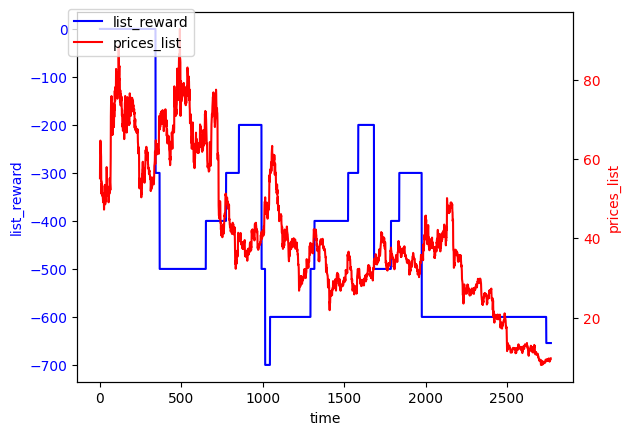

In [17]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(balances, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')


fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()